In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import pandas as pd
import numpy as np
from sklearn.utils import resample

import cv2 as cv
import matplotlib.pyplot as plt
from skimage.transform import resize

from torch.utils.tensorboard import SummaryWriter
import torchmetrics

import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split

c:\Users\micha\Envs\UKSH\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu" 
device = torch.device(dev) 

In [6]:
class HazelNet(nn.Module):
    
    def __init__(self):
        # wofür ist das da?
        super(HazelNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
  
        # over-write the first conv layer to be able to read images
        # as resnet18 reads (3,x,x) where 3 is RGB channels
        # whereas MNIST has (1,x,x) where 1 is a gray-scale channel
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        self.fc_in_features = self.resnet.fc.in_features 
        # remove the last layer of resnet18 (linear layer which is before avgpool layer)
        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))
        #self.resnet.fc kann das letzte layer ansprechen und ersetzen bei bedarf

        # add linear layers to compare between the features of the two images
        self.fc = nn.Sequential(
            nn.Linear(self.fc_in_features, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            nn.Linear(1024, 128),
            )        
       
        # initialize the weights
        self.resnet.apply(self.init_weights)
        self.fc.apply(self.init_weights)   
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)
    
    # Erstellt NN mit dem input, inputs ist unser batch
    def forward_once(self, inputs):
        output = self.resnet(inputs)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    
    def distance_layer(self, vec1, vec2):
        cos = torch.nn.CosineSimilarity()
        similarity = cos(vec1, vec2) 
        return similarity

    def forward(self, template, img):
        output1 = self.forward_once(template)
        output2 = self.forward_once(img)

        output = self.distance_layer(output1,output2)
 
        return output   

# Parameters

In [7]:
hidden_dim = 128
hidden_dim2 = 64
hidden_dim3 = 32

do_learn = True
save_frequency = 2
batch_size = 40 if torch.cuda.is_available() else 64

learning_rate = 0.005
num_epochs = 100
weight_decay = 0.1
momentum = 0.9

loss_history = []
r2_history = []


loss_history2 = []
r2_history2 = []


# Splitting into Train, Val and Test

In [8]:
images = np.load("images.npy", allow_pickle=True ).astype(float)
pairs = np.load("imagePairs.npy", allow_pickle=True ).astype(int)
labels = np.load("imageLabels.npy", allow_pickle=True ).astype(float)

pairs = pairs[500:3500]
labels = labels[500:3500]

# Split into Train, Val and Test
rndidx = np.random.choice(np.arange(0,  len(pairs)), size = len(pairs) )
trainidx, remain = np.array_split(rndidx, [int(0.7 * len(rndidx))])
validx, testidx = np.array_split(remain, [int(0.5 * len(remain))])

trainpairs = pairs[trainidx]
valpairs = pairs[validx]
testpairs = pairs[testidx]

trainlabels = labels[trainidx]
vallabels = labels[validx]
testlabels = labels[testidx]

<AxesSubplot: ylabel='Count'>

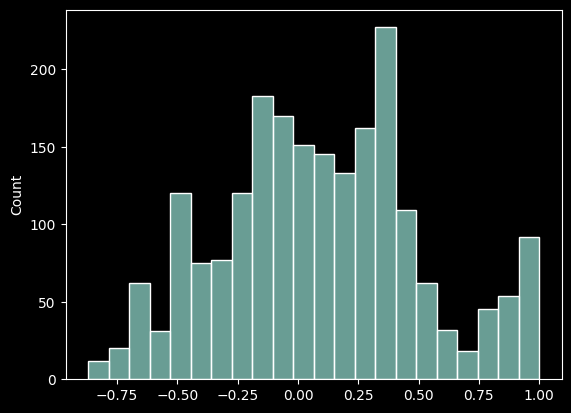

In [9]:
sns.histplot(trainlabels)

<AxesSubplot: ylabel='Count'>

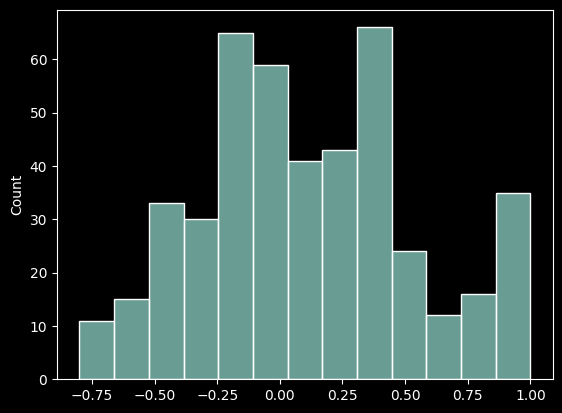

In [10]:
sns.histplot(vallabels)

In [11]:
# Class for creating a Dataset which the dataloader from pytroch needs to create a wrapper for iterating though the data
class CustomImageDataset(Dataset):
    def __init__(self, root, pairs, labels, images):
       self.pairs = pairs
       self.labels = labels
       self.images = images
       
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        element = self.pairs[idx]
        label = self.labels[idx]
        template = self.images[self.pairs[idx][0]]
        img = self.images[self.pairs[idx][1]]

        template, img = resize(template, (224, 224)), resize(img, (224, 224,))

        img = np.expand_dims(img, axis=0)
        template = np.expand_dims(template, axis=0)
       

        return  template.astype(np.float32), img.astype(np.float32), label.astype(np.float32) 

In [12]:
model = HazelNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

training_data = CustomImageDataset("", pairs=trainpairs, labels=trainlabels, images=images)
val_data = CustomImageDataset("",  pairs=valpairs, labels=vallabels, images=images)
test_data = CustomImageDataset("", pairs=testpairs, labels=testlabels, images=images)

# Create data loaders.
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)


In [13]:
def train_one_epoch(epoch_index):
    running_loss = 0
    running_mse = 0
    running_r2 = 0

    total_loss = 0
    total_r2 = 0
    
    for batch_idx, data in enumerate(train_loader):
        templates, images, targets = data
        
        templates = templates.to(device)
        images = images.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()

        outputs = model(templates, images)

        loss = criterion(outputs, targets)
        loss.backward()

        optimizer.step()

        rscore = r2score(outputs, torch.tensor(targets).squeeze())
        running_r2 += rscore
        total_r2 += rscore

        mse = msecalc(outputs, torch.tensor(targets).squeeze())
        running_mse += mse
        
        running_loss += loss.item()
        total_loss += loss.item()

        if batch_idx % 100 == 80:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tR2Score: {} \tMSE: {}'.format(
            epoch_index, batch_idx * len(templates), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), running_mse / 100, running_r2 / 100, running_mse / 100 ))
            running_loss = 0
            running_mse = 0
            running_r2 = 0

    avg_loss = total_loss / (batch_idx + 1)
    avg_r2 = total_r2 / (batch_idx + 1)   

    del templates
    del images
    del targets

    torch.cuda.empty_cache()

    return avg_loss, avg_r2

model.train(False) <- Ich weiß nicht warum, aber das hier sorgt dafür, dass die Werte imme rauf 1.0 predicted werden für die validation daten. Zumindest in den ersten 20 epochen

with torch.no_grad():
     print(model(vtemplates,vimages))



In [14]:
torch.cuda.empty_cache()
tb = SummaryWriter()
best_vloss = 1000000
msecalc = torchmetrics.MeanSquaredError().to(device)
r2score = torchmetrics.R2Score().to(device)

for epoch in range (num_epochs):

    model.train(True)
    avg_loss, avg_r2 = train_one_epoch(epoch)
    torch.cuda.empty_cache()
    model.train(False)

    running_vloss = 0
    running_vmse = 0
    running_vr2 = 0
    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vtemplates, vimages, vtargets = vdata
            vtemplates = vtemplates.to(device)
            vimages = vimages.to(device)
            vtargets = vtargets.to(device)

            voutputs = model(vtemplates,vimages)
            vloss =  criterion(voutputs, vtargets)
            running_vloss += vloss.item()

            vrscore = r2score(voutputs, torch.tensor(vtargets).squeeze())
            running_vr2 += vrscore

            vmse = msecalc(voutputs, torch.tensor(vtargets).squeeze())
            running_vmse += vmse
            print(f"Berechneter Loss für VALIDATION {vloss.item()} Total loss aktuell {running_vloss}, voutputs ist: {voutputs}")
       
        avg_vloss = running_vloss / (i+1)
        avg_vr2 = running_vr2  / (i+1)
        avg_vmse = running_vmse / (i+1)

        print('EPOCH RESULTS: Train Loss {} Valid Loss {} Train R2 {} Valid R2 {} '.format(avg_loss, avg_vloss, avg_r2, avg_vr2))
      #  print('EPOCH RESULTS: Train Loss {0:.{1}f} Valid Loss {2} Train R2 {3} Valid R2 {0} '.format(avg_loss, avg_vloss, avg_r2, avg_vr2))

        tb.add_scalars('Training vs. Validation Loss',
                        { 'Training' : avg_loss, 'Validation' : avg_vloss},
                        epoch + 1)


        tb.add_scalars('Training vs. Validation R2',
                        { 'Training' : avg_r2, 'Validation' : avg_vr2},
                        epoch + 1)
        tb.flush()       


    #Track best performance, and save the model's state
        #if avg_vloss < best_vloss:
         #   best_vloss = avg_vloss
          #  torch.save(model.state_dict(), "bestmodel2")


KeyboardInterrupt: 

In [ ]:

for i in range(10,50):

    fig, ax = plt.subplots(1,2)
    fig.suptitle(trainlabels[i])
    ax[0].imshow(images[trainpairs[i][0]])
    ax[1].imshow(images[trainpairs[i][1]])
    #print(labelTest[i])
    fig.show()

# HazelNetTesting

In [15]:
model = HazelNet().to(device)
model.load_state_dict(torch.load("bestmodel2"))

<All keys matched successfully>

In [16]:
def predict (model, template, img):
    model.eval()
    with torch.no_grad():
        ypred = model(template,img)
    return ypred

In [20]:
predictions = []
labels = []

for i,data in tqdm(enumerate(test_loader)):
  templates, images, targets = data
  templates = templates.to(device)
  images = images.to(device)
  targets = targets.to(device)
  labels.extend(targets)
  predictions.extend(predict(model = model, template = templates, img = images))


12it [00:03,  3.56it/s]


In [ ]:

for i in range(10,50):

    fig, ax = plt.subplots(1,2)
    fig.suptitle(trainlabels[i])
    ax[0].imshow(images[trainpairs[i][0]])
    ax[1].imshow(images[trainpairs[i][1]])
    #print(labelTest[i])
    fig.show()